We want to evaluate the deterministic, stationary policy shown in the figure below, where each arrow represents the prescribed action in each cell. This is the same policy evaluated in Homework 1; however, here we assume that the model is unknown to the agent. Notice that for running the model-free algorithms, there should still be an environment model that can generate the samples. **For instance, you may have an environment function in your code that takes a state, along with an action, and outputs a next state sampled according to the true (unknown to the agent) transition probabilities and a reward according to the true (unknown to the agent) reward function.**


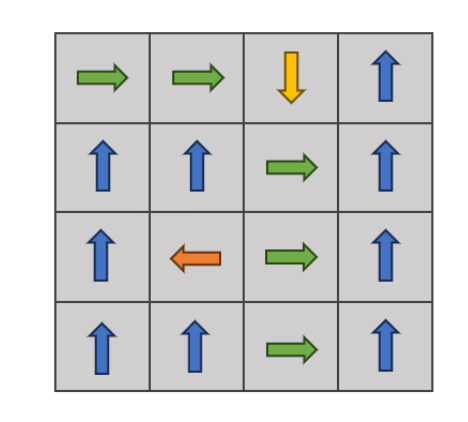

Run a first visit MC algorithm to evaluate this policy. Describe how you ensure that each state is visited often enough so that the value function for states are accurately estimated. Pick a termination criteria and justify it. Report the value function at all states after the algorithm terminates.

# Problem 1 Answers:
## 1. How do you ensure each state is visited often enough?
I initialized the trajectory to randomly start at different states (except the mountain state).
## 2. Pick a termination criteria and justify it:
After at least 1000 episodes, I would periodicly (every 500 episodes) compute the average (16 dimensional) of the last 5 to 10 percent of value functions and also compute the mean (16 dimensions) last 5 percent of the value functions. If the difference (L2) in the mean of the value functions was less than a small threshold, I terminated the algorithm.

## 3. Report the value function after the algorithm has terminated:
Value Function from Monte Carlo First Visit Method: (See on the next page).

In [172]:
import numpy as np
from transition import P # import transition matrix from HW 1. Use it to sample probabilities of going from 
import matplotlib.pyplot as plt

In [440]:
# First, we will need to create an environment function that takes a state, and action, and outputs a next state 
# with true transition probabilities.


# s,a --> s
a = ['r', 'l', 'u', 'd']
s = np.arange(16)
policy = np.array([['r', 'r', 'd', 'u'], 
                    ['u', 'u', 'r', 'u'],
                    ['u', 'l', 'r', 'u'], 
                    ['u', 'u', 'r', 'u']])

def envSim(s, P): 
    """
    This function simulates an environment
    """
    next_state = int(np.random.choice(16, 1, p = P[s]))
    # for example, if we start in state 0, we go right with p = 0.85 and end up in state 1. 
    # we stay in s0 with p = 0.1. go left to state 4 with p = 0.05. This is all encoded in the P matrix. 
    reward = 0
    if next_state == 3:
        reward = 1
    if next_state == 5:
        reward = -1
    return next_state, reward         

envSim(1, P)

next_state = -1

def generateTrajectory(steps):
    """
    This function generates a trajectory based on the environment.
    The first state is generated randomly (uniform distribution)
    """
    trajectory = []
    for i in range(steps):
        
        if i == 0: # this block is for initializing the trajectory
            # randomly start at any state. This allows for good exploration of the states! 
            first_state = np.random.randint(low = 0, high=16)
            while (first_state == 10): # cannot start at mountain state 
                first_state = np.random.randint(low = 0, high = 16) # draw another random start that is not the

            trajectory.append(first_state) # append first state. 
            
            if (first_state != 3) and (first_state != 5): # if we did not start the lightning bolt or the 
                # treasure set the first_state to current_state 
                current_state = first_state

            else:
                # return the episode
                return np.array(trajectory)

        # get the next state based on the current state
        next_state, reward = envSim(current_state, P)
        trajectory.append(next_state)
        current_state = next_state # let the next state now be equal to the current state, as the current 
        # state is what we want to run envSim with.
        if next_state ==3 or next_state == 5: # exit criteria
            if i == steps - 1:  
                print('overflow!')
                
            return np.array(trajectory)
            break
        


np.random.seed(4)
# Initialize v(s) = some 16 dimensional vector
# Initialize G(s) = empty 16 dimensional vector

# Generate sample trajectory according to probabilities from transition matrix
# for each state in sample trajectory:
    # let ts be the first time the state in sample trajectory is visited. For example, if trajectory is:
    # 8, 4, 0, 1, 2, 6, 7, 6, 7, 3, then, ts = 2 for state 4 (start with 1 index)
    # G = sum from 2 to 10 of gamma^


V_pi_MC = np.zeros((16,1))
Gs = np.zeros((16,1))
gamma = 0.95
R = np.zeros((16,1))
R[3] = 1
R[5] = -1
episodes_MC = 10000
V_pi_MC_history = np.zeros((16,episodes_MC))
count_bogus_instances = 0
Ns = np.zeros((16,1))
distance_last_5 = []
breakpoint_MC_method = -99 # dummy variable

for episode in range(episodes_MC):
    sample_trajectory = generateTrajectory(30)
    
    for idx, s in enumerate(sample_trajectory):
        
        ts = np.argwhere(sample_trajectory == s)[0] # ts is the first timestep where the state s is in 
        # the trajectory. This will be important for making sure we only do first-visit MC sampling.

        if ts != idx:
            continue # go to the next iteration of the loop. this is first-visit MC sampling, so, we do not
            # compute the cummulative reward for this state again in this trajectory.
        else:
            Ns[s] += 1 #increase number of samples of s by 1.
        # this is the first step from which we compute the first step MC method discounted rewards

        last_state = sample_trajectory[-1] 
        reward = 1 if last_state == 3 else -1 # compute the appropriate reward for the trajectory.
        
        # compute return/reward from first-visit all the way to the end of the episode.
        temp_G = gamma**(sample_trajectory.shape[0] - ts - 1) * reward
        #print('computing', gamma, 'to the pwr of', sample_trajectory.shape[0] - ts, 'times', reward)
        
        # to re-average G, multiply original G * number of samples: (temp_G + G[s]) * 1 / Ns[s]

        V_pi_MC[s] = V_pi_MC[s] + (1/Ns[s]) * (temp_G - V_pi_MC[s]) # recompute average for state
        
        
    # Exit Criteria for evaluation. Get to a point where the difference betweeen the 90th - 95th 
    # percentile average is less than 0.01 in euclidean distance from the mean of 95th - 100th percent of samples
    
    V_pi_MC_history[:,episode] = V_pi_MC.reshape(16,)

    if (episode >= 1000) and (episode % 500 == 0):
        V_pi_MC_history_last_90_95_percent = V_pi_MC_history[:, int(0.90 * episode): int(0.95 *episode)].mean(axis = 1) # for example
        # this gets all rows, 90 : 95, 9000 : 9500 as the history
        V_pi_MC_history_last_5_percent = V_pi_MC_history[:, int(0.95 * episode): episode-1].mean(axis = 1)
        # if L2 norm less than 0.01, terminate
        temp_distance = np.linalg.norm(V_pi_MC_history_last_90_95_percent - V_pi_MC_history_last_5_percent)
        distance_last_5.append(temp_distance)
        if temp_distance < 0.01:
            breakpoint_MC_method = episode
            break
        
        
    
        
print("Value Function from Monte Carlo First Visit Method:\n", V_pi_MC)
#plt.plot(distance_last_5)

Value Function from Monte Carlo First Visit Method:
 [[ 0.54401042]
 [ 0.57942516]
 [ 0.73478732]
 [ 1.        ]
 [ 0.44369541]
 [-1.        ]
 [ 0.77241174]
 [ 0.92751153]
 [ 0.41002604]
 [ 0.26429816]
 [ 0.        ]
 [ 0.86762559]
 [ 0.42534723]
 [ 0.25933029]
 [ 0.73349869]
 [ 0.81603562]]


# Problem 2:
Run a one step temporal difference learning algorithm to evaluate this policy. Describe how you ensure that each state is visited often enough so that its value is estimated accurately. Pick a termination criteria and justify it. Report the value function at all states after the algorithm terminates. 


## 1. How do you ensure each state is visited often enough?
I initialized the trajectory to randomly start at different states (except the mountain state).
## 2. Pick a termination criteria and justify it:
After at least 1000 episodes, I would periodicly (every 500 episodes) compute the average (16 dimensional) of the last 5 to 10 percent of value functions and also compute the mean (16 dimensions) last 5 percent of the value functions. If the difference (L2) in the mean of the value functions was less than a small threshold, I terminated the algorithm.

## 3. Report the value function after the algorithm has terminated:
Value Function from temporal difference method on the next page.

In [441]:
# Initialize v_pi to 0 for all states
v_pi_TD = np.zeros((16,1))
alpha = 0.05
gamma = 0.95
episodes_TD = 10000
v_pi_TD_history = np.zeros((16,episodes_TD))
np.random.seed(0)
distance_last_5_TD = []
breakpoint_TD_method = -99 # dummy variable

# Sample:
for episode in range(episodes_TD):
    samples = generateTrajectory(30)

    # Repeat until episode terminaltes:
    for n, s in enumerate(samples):
        reward = 0 # initialize reward variable
        # take action according to pi(a | s)
        
        # below, we get the current observed reward based on the state in the trajectory
        if s == 3:
            reward = 1
        if s == 5:
            reward = -1
         
        
        if n != (len(samples) -1): # not looking at last state, update value function with the next state included
            next_state = samples[n+1]
            v_pi_TD[s] = v_pi_TD[s] + alpha * (reward + (gamma * v_pi_TD[next_state]) - v_pi_TD[s])
            
        if n == (len(samples) - 1): # last state in trajectory, update value function without the next state
            # because there is not a next state in trajectory.
            v_pi_TD[s] = v_pi_TD[s] + alpha * (reward - v_pi_TD[s])

    
    
    # append value function history after each iteration for plotting
    v_pi_TD_history[:,episode] = v_pi_TD.reshape(16,) 
    
    # exit criteria:
    if (episode >= 1000) and (episode % 500 == 0):
        v_pi_TD_history_last_90_95_percent = v_pi_TD_history[:, int(0.90 * episode): int(0.95 *episode)].mean(axis = 1) # for example
        # this gets all rows, 90 : 95, 9000 : 9500 as the history
        v_pi_TD_history_last_5_percent = v_pi_TD_history[:, int(0.95 * episode): episode-1].mean(axis = 1)
        # if L2 norm less than 0.01, terminate
        temp_distance = np.linalg.norm(v_pi_TD_history_last_90_95_percent - v_pi_TD_history_last_5_percent)
        distance_last_5_TD.append(temp_distance)
        if temp_distance < 0.1:
            breakpoint_TD_method = episode
            break
    if (episode == episodes_TD - 1):
        breakpoint_TD_method = episode
        
        

print("Value Function from Temporal Difference Method:", v_pi_TD)
#plt.plot(distance_last_5_TD)

Value Function from Temporal Difference Method: [[ 0.60757782]
 [ 0.67028347]
 [ 0.78546054]
 [ 1.        ]
 [ 0.5457564 ]
 [-0.9999997 ]
 [ 0.85325915]
 [ 0.93429183]
 [ 0.4760383 ]
 [ 0.39567103]
 [ 0.        ]
 [ 0.88148897]
 [ 0.42484774]
 [ 0.34828543]
 [ 0.752767  ]
 [ 0.8308173 ]]


# Problem 3:
Plot the error (L2/euclidean distance between value function after the nth episode and the true value function).
See plot after the next block of code.

Text(0.5, 1.0, 'Problem 3: MC and TD Method Error')

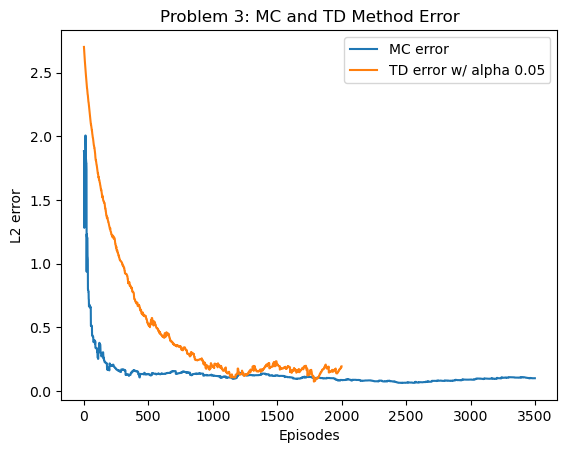

In [442]:
v_pi_true = np.array([0.562, 0.603, 0.737, 1.000,
                      0.447,-1.000,0.775,0.930,
                      0.414,0.317, 0.000, 0.873,
                      0.386,0.326,0.747, 0.818])

error_MC = [np.linalg.norm(V_pi_MC_history[:,i] - v_pi_true) for i in range(breakpoint_MC_method)]
error_MC = np.array(error_MC).reshape(breakpoint_MC_method, -1)

error_TD = [np.linalg.norm(v_pi_TD_history[:,i] - v_pi_true) for i in range(breakpoint_TD_method)]
error_TD = np.array(error_TD).reshape(breakpoint_TD_method, -1)

plt.plot(error_MC, label = 'MC error')
plt.plot(error_TD, label = 'TD error w/ alpha ' + str(alpha))
plt.xlabel('Episodes')
plt.ylabel('L2 error')

plt.legend()
plt.title('Problem 3: MC and TD Method Error')